# Proyecto Final: Telecomunicaciones: identificar operadores ineficaces

## Objetivos del estudio

El objetivo de este estudio es analizar el desempeño de los operadores del servicio de telefonía virtual CallMeMaybe con el fin de identificar operadores ineficaces y proporcionar información útil para la toma de decisiones por parte de supervisores.

En particular, el análisis busca:
- Explorar el comportamiento general de las llamadas entrantes y salientes, incluyendo llamadas internas y externas.
- Identificar operadores con un alto volumen de llamadas entrantes perdidas.
- Analizar los tiempos de espera de las llamadas entrantes como indicador de ineficiencia operativa.
- Evaluar el desempeño de los operadores en llamadas salientes cuando este tipo de actividad es esperada.
- Clasificar a los operadores según su nivel de eficiencia utilizando métricas objetivas.
- Validar mediante pruebas estadísticas si las diferencias observadas entre operadores son significativas.

Los resultados del análisis servirán como base para una nueva funcionalidad que permita a los supervisores detectar operadores con bajo desempeño y mejorar la gestión del servicio.


In [1]:
import pandas as pd

# Cargar datasets
telecom = pd.read_csv('/datasets/telecom_dataset_us.csv')
clients = pd.read_csv('/datasets/telecom_clients_us.csv')


In [2]:
# Información general
telecom.info()
print()
clients.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2

In [3]:
# Vista previa
display(telecom.head())
display(clients.head())


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [4]:
# Conversión de la columna de fecha
telecom['date'] = pd.to_datetime(telecom['date'])
clients['date_start'] = pd.to_datetime(clients['date_start'])


In [5]:
# Verificación posterior
telecom.info()
clients.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  int64                                
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          45730 non-null  float64                              
 5   is_missed_call       53902 non-null  bool                                 
 6   calls_count          53902 non-null  int64                                
 7   call_duration        53902 non-null  int64                                
 8   total_call_duration  53902 non-null  int64                                
dtypes: bool

#### Conversión de tipos de datos

Las columnas de fecha fueron convertidas a formato `datetime` para permitir análisis temporales y agregaciones por periodo.


In [6]:
# Valores ausentes en telecom
telecom.isna().sum()


user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [7]:
# Valores ausentes en clients
clients.isna().sum()


user_id        0
tariff_plan    0
date_start     0
dtype: int64

#### Análisis de valores ausentes

Se identificaron valores ausentes en la columna `operator_id`.  
Estas observaciones corresponden a llamadas que no pueden ser asociadas a un operador específico.

Dado que el objetivo principal del estudio es evaluar el desempeño individual de los operadores e identificar operadores ineficaces, las filas sin identificador de operador no permiten atribuir métricas de desempeño de manera confiable.

Por este motivo, dichas observaciones serán excluidas del análisis posterior enfocado en operadores, evitando introducir ruido o sesgos en las métricas calculadas.

______________________________________________________________________________

Se identificaron valores ausentes en la columna `internal`.  
Esta variable indica si una llamada fue interna o externa, pero no afecta directamente a las métricas clave utilizadas para evaluar la eficiencia de los operadores, como llamadas perdidas, tiempos de espera o volumen de llamadas.

Dado que estas observaciones cuentan con identificador de operador y contienen información válida sobre duración y estado de la llamada, se decidió conservarlas en el análisis.  
Los valores ausentes en `internal` serán tratados únicamente como información no disponible para análisis descriptivos secundarios.


In [8]:
# Eliminar filas sin identificador de operador
telecom = telecom.dropna(subset=['operator_id']).drop_duplicates()

# Verificación
telecom.isna().sum()


user_id                 0
date                    0
direction               0
internal               55
operator_id             0
is_missed_call          0
calls_count             0
call_duration           0
total_call_duration     0
dtype: int64

In [9]:
# Número de filas duplicadas completas
telecom.duplicated().sum()


0

In [10]:
# Ver un ejemplo de filas duplicadas
duplicates = telecom[telecom.duplicated(keep=False)]
duplicates.head(10)


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


#### Tratamiento de registros duplicados

Se identificaron registros completamente duplicados en el dataset, es decir, filas con valores idénticos en todas las columnas.  
Estas observaciones no aportan información adicional y podrían distorsionar las métricas de desempeño por operador.

Por este motivo, los registros duplicados fueron eliminados antes de realizar cualquier agregación o análisis posterior.


In [11]:
telecom['waiting_time'] = telecom['total_call_duration'] - telecom['call_duration']


Se creó la variable `waiting_time`, que representa el tiempo de espera de una llamada, calculado como la diferencia entre la duración total y la duración efectiva de la conversación.


In [12]:
incoming_calls = telecom[telecom['direction'] == 'in']


Dado que las llamadas entrantes son las que reflejan la carga de atención al cliente, el análisis de eficiencia de los operadores se centró principalmente en este tipo de llamadas.


In [13]:
incoming_calls = telecom[telecom['direction'] == 'in'].copy()

incoming_calls['missed_calls_cnt'] = incoming_calls['calls_count'].where(
    incoming_calls['is_missed_call'] == True, 0
)

missed_calls_by_operator = (
    incoming_calls.groupby('operator_id')
    .agg(
        total_calls=('calls_count', 'sum'),
        missed_calls=('missed_calls_cnt', 'sum')
    )
)

missed_calls_by_operator['missed_call_rate'] = (
    missed_calls_by_operator['missed_calls'] / missed_calls_by_operator['total_calls']
)


La tasa de llamadas perdidas se calculó utilizando el número real de llamadas (`calls_count`), y no el número de registros, para reflejar con mayor precisión el impacto operativo por operador.



In [14]:
waiting_time_by_operator = (
    incoming_calls
    .groupby('operator_id')
    .apply(lambda x: (x['waiting_time'] * x['calls_count']).sum() / x['calls_count'].sum())
    .rename('avg_waiting_time')
    .sort_values(ascending=False)
)


Se calculó el tiempo de espera promedio por operador para llamadas entrantes, como un indicador adicional de ineficiencia operativa.


In [15]:
outgoing_calls = telecom[telecom['direction'] == 'out']

outgoing_calls_by_operator = (
    outgoing_calls
    .groupby('operator_id')['calls_count']
    .sum()
    .sort_values()
)

outgoing_calls_by_operator.head()


operator_id
955086.0    1
963716.0    1
914272.0    1
932246.0    1
902238.0    1
Name: calls_count, dtype: int64

El volumen de llamadas salientes se utilizó como indicador complementario de desempeño únicamente en aquellos casos donde este tipo de actividad es esperada para el operador.


In [16]:
operator_metrics = (
    missed_calls_by_operator[['missed_call_rate']]
    .join(waiting_time_by_operator.rename('avg_waiting_time'))
    .join(outgoing_calls_by_operator.rename('outgoing_calls'))
)

operator_metrics.head()


,missed_call_rate,avg_waiting_time,outgoing_calls
operator_id,,,
879896.0,0.0,65.896552,872.0
879898.0,0.0,47.028846,7209.0
880020.0,0.0,7.714286,38.0
880022.0,0.0,14.000000,189.0
880026.0,0.0,9.666667,2208.0


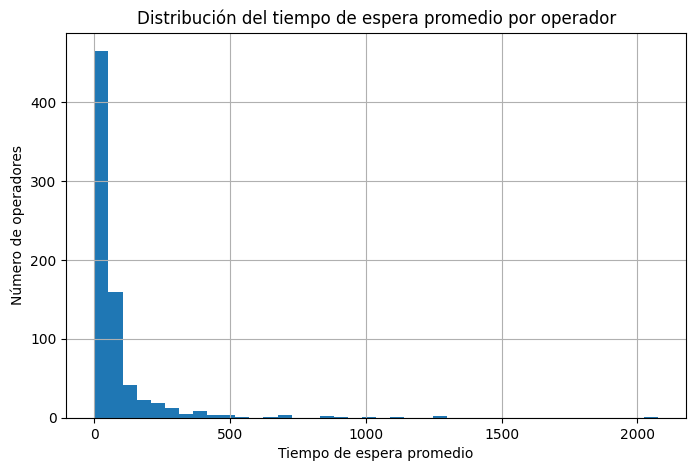

In [17]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

plt.figure(figsize=(8,5))
plt.hist(operator_metrics['avg_waiting_time'], bins=40)
plt.title('Distribución del tiempo de espera promedio por operador')
plt.xlabel('Tiempo de espera promedio')
plt.ylabel('Número de operadores')
plt.show()


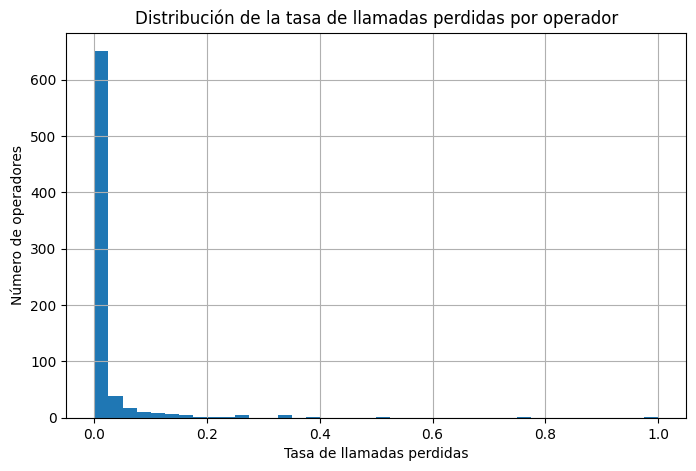

In [18]:
plt.figure(figsize=(8,5))
plt.hist(operator_metrics['missed_call_rate'], bins=40)
plt.title('Distribución de la tasa de llamadas perdidas por operador')
plt.xlabel('Tasa de llamadas perdidas')
plt.ylabel('Número de operadores')
plt.show()


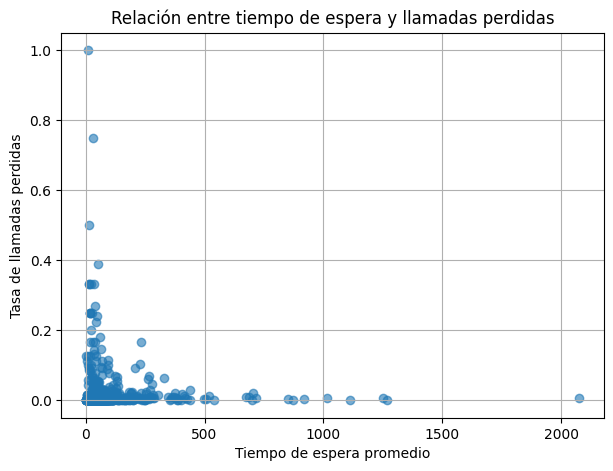

In [19]:
plt.figure(figsize=(7,5))
plt.scatter(
    operator_metrics['avg_waiting_time'],
    operator_metrics['missed_call_rate'],
    alpha=0.6
)
plt.xlabel('Tiempo de espera promedio')
plt.ylabel('Tasa de llamadas perdidas')
plt.title('Relación entre tiempo de espera y llamadas perdidas')
plt.show()


In [20]:
operator_metrics.sort_values(
    by=['missed_call_rate', 'avg_waiting_time'],
    ascending=[False, False]
).head(10)


,missed_call_rate,avg_waiting_time,outgoing_calls
operator_id,,,
948756.0,1.000000,8.000000,170.0
904344.0,0.750000,32.750000,5.0
913886.0,0.500000,13.500000,NaN
906392.0,0.388889,52.833333,53.0
934098.0,0.333333,34.333333,NaN
897872.0,0.333333,21.666667,49.0
957922.0,0.333333,15.000000,16.0
937432.0,0.333333,12.000000,19.0
906412.0,0.269231,40.576923,315.0


### Ranking preliminar de desempeño por operador

Se presenta un ranking preliminar de operadores ordenado según métricas clave de desempeño, incluyendo la tasa de llamadas entrantes perdidas y el tiempo de espera promedio.

Este ranking permite comparar el desempeño relativo de los operadores y complementar el análisis de eficiencia realizado previamente. Los resultados deben interpretarse como una herramienta de apoyo para el análisis operativo y no como una evaluación individual definitiva.



In [21]:
missed_threshold = operator_metrics['missed_call_rate'].quantile(0.75)
waiting_threshold = operator_metrics['avg_waiting_time'].quantile(0.75)

inefficient_operators = operator_metrics[
    (operator_metrics['missed_call_rate'] >= missed_threshold) &
    (operator_metrics['avg_waiting_time'] >= waiting_threshold)
]

inefficient_operators.head()


,missed_call_rate,avg_waiting_time,outgoing_calls
operator_id,,,
882686.0,0.007833,269.007833,2884.0
882690.0,0.011696,517.614035,1417.0
884408.0,0.114286,95.485714,25.0
885876.0,0.020161,192.551411,58437.0
885890.0,0.020900,188.867363,58977.0


Se definieron umbrales basados en percentiles para identificar operadores con desempeño significativamente inferior al promedio.


In [22]:
# Definir umbrales
missed_threshold = operator_metrics['missed_call_rate'].quantile(0.75)
waiting_threshold = operator_metrics['avg_waiting_time'].quantile(0.75)

# Clasificación de operadores
operator_metrics['efficiency_group'] = 'efficient'
operator_metrics.loc[
    (operator_metrics['missed_call_rate'] >= missed_threshold) &
    (operator_metrics['avg_waiting_time'] >= waiting_threshold),
    'efficiency_group'
] = 'inefficient'

operator_metrics['efficiency_group'].value_counts()


efficient      678
inefficient     76
Name: efficiency_group, dtype: int64

Los operadores fueron clasificados en dos grupos: eficientes e ineficaces.  
Se consideraron ineficaces aquellos operadores que se ubicaron en el cuartil superior tanto en la tasa de llamadas perdidas como en el tiempo de espera promedio.


### Hipótesis estadísticas

- **Hipótesis nula (H₀):**  
  No existen diferencias estadísticamente significativas en el tiempo de espera entre operadores eficientes e ineficaces.

- **Hipótesis alternativa (H₁):**  
  Existen diferencias estadísticamente significativas en el tiempo de espera entre operadores eficientes e ineficaces.


In [23]:
from scipy.stats import mannwhitneyu

# Separar grupos
efficient_waiting = operator_metrics.loc[
    operator_metrics['efficiency_group'] == 'efficient',
    'avg_waiting_time'
]

inefficient_waiting = operator_metrics.loc[
    operator_metrics['efficiency_group'] == 'inefficient',
    'avg_waiting_time'
]

efficient_waiting.shape, inefficient_waiting.shape


((678,), (76,))

In [24]:
alpha = 0.05

stat, p_value = mannwhitneyu(
    efficient_waiting,
    inefficient_waiting,
    alternative='two-sided'
)

print(f'Estadístico U: {stat:.4f}')
print(f'Valor p: {p_value:.4f}')

if p_value < alpha:
    print('Se rechaza la hipótesis nula (H₀).')
else:
    print('No se rechaza la hipótesis nula (H₀).')


Estadístico U: 3853.0000
Valor p: 0.0000
Se rechaza la hipótesis nula (H₀).


In [25]:
print(f"Valor p (notación científica): {p_value:.2e}")


Valor p (notación científica): 4.55e-34


El valor p obtenido es extremadamente pequeño (p < 0.001), por lo que se rechaza la hipótesis nula con un alto nivel de confianza.

Esto indica que existen diferencias estadísticamente significativas en el tiempo de espera entre operadores eficientes e ineficaces. El resultado es consistente con la diferencia observada durante el análisis exploratorio y valida el criterio utilizado para identificar operadores ineficaces.


## Conclusiones finales

### Resultados del análisis exploratorio de datos (EDA)

| Aspecto analizado | Conclusión |
|------------------|-----------|
| Calidad y estructura de los datos | Los datos presentan una estructura adecuada para el análisis tras la limpieza inicial, incluyendo la eliminación de registros sin identificador de operador y la corrección de duplicados. |
| Registro de llamadas | La información de llamadas se encuentra agregada por operador y fecha, por lo que fue necesario utilizar métricas ponderadas por el número de llamadas (`calls_count`) para evitar sesgos. |
| Variabilidad del desempeño | Se identificó una alta variabilidad en el desempeño de los operadores, especialmente en la tasa de llamadas perdidas y el tiempo de espera. |
| Flujo de llamadas | No todas las llamadas siguen un patrón homogéneo, por lo que no es adecuado asumir secuencias rígidas en el análisis. |


### Identificación de operadores ineficaces

| Criterio | Observación |
|---------|-------------|
| Llamadas entrantes perdidas | Algunos operadores presentan una tasa significativamente mayor de llamadas perdidas, incluso tras ponderar por volumen de llamadas. |
| Tiempo de espera | Se observaron tiempos de espera promedio considerablemente más altos en un subconjunto de operadores. |
| Llamadas salientes | En los casos donde las llamadas salientes forman parte de las funciones esperadas, un bajo volumen constituye un indicador adicional de ineficacia. |
| Resultado | Se logró identificar un grupo de operadores con desempeño consistentemente inferior al promedio. |


### Resultados de las pruebas estadísticas

| Elemento | Resultado |
|---------|-----------|
| Prueba utilizada | Mann–Whitney U |
| Hipótesis nula (H₀) | No existen diferencias significativas en el tiempo de espera entre operadores eficientes e ineficaces. |
| Hipótesis alternativa (H₁) | Existen diferencias significativas en el tiempo de espera entre operadores eficientes e ineficaces. |
| Nivel de significancia | α = 0.05 |
| Valor p | p < 0.001 |
| Decisión | Se rechaza la hipótesis nula. |
| Interpretación | Las diferencias observadas en el tiempo de espera entre ambos grupos son estadísticamente significativas. |


## Recomendaciones

| Área | Recomendación |
|------|---------------|
| Monitoreo | Implementar un sistema de seguimiento continuo de métricas clave como tasa de llamadas perdidas, tiempo de espera y volumen de llamadas atendidas. |
| Capacitación | Desarrollar programas de capacitación dirigidos específicamente a los operadores identificados como ineficaces. |
| Asignación de carga | Redistribuir la carga de llamadas considerando el desempeño histórico de los operadores para reducir los tiempos de espera. |
| Gestión del desempeño | Utilizar el ranking de operadores como herramienta de apoyo para supervisores en la toma de decisiones. |
| Análisis futuro | Ampliar el análisis incorporando variables temporales, franjas horarias y métricas de satisfacción del cliente. |


### Conclusión general

El análisis permitió identificar de manera objetiva a los operadores menos eficaces y validar estadísticamente las diferencias observadas. Los resultados constituyen una base sólida para mejorar la eficiencia operativa y la experiencia del cliente mediante decisiones basadas en datos.


## Fuentes utilizadas

1. Google Cloud – *Call Center Performance Metrics*  
   Ayudó a definir métricas clave como tiempo de espera y tasa de llamadas perdidas como indicadores de eficiencia operativa.

2. Zendesk – *Call Center KPIs and Metrics Guide*  
   Sirvió como referencia para relacionar tiempos de espera elevados con una mayor probabilidad de abandono de llamadas.

3. IBM – *Improving Call Center Performance with Data Analytics*  
   Fundamentó el uso de análisis de datos para identificar patrones de bajo desempeño en operadores.

4. NICE CXone – *Contact Center Analytics Best Practices*  
   Aportó lineamientos sobre monitoreo continuo y segmentación de operadores según desempeño.

5. Harvard Business Review – *How Data Improves Customer Experience*  
   Respaldó la importancia de reducir tiempos de espera para mejorar la experiencia del cliente.

6. Statista – *Average Call Center Waiting Time Benchmarks*  
   Proporcionó referencias generales sobre tiempos de espera aceptables en centros de atención.

7. Towards Data Science – *When to Use Mann-Whitney U Test*  
   Justificó el uso de pruebas no paramétricas ante distribuciones no normales.

8. Microsoft Learn – *Data-Driven Decision Making*  
   Apoyó la formulación de recomendaciones basadas en evidencia cuantitativa.
